In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import fiona
import importlib
import numpy.ma as ma

In [2]:
from xgcm import Grid

In [3]:
dfmg = pd.read_csv("dfmg.csv")
dfgamma = pd.read_csv("gamman.csv", names=['PROFILE_NUMBER', 'gamman'])
dfmg['gamman'] = dfgamma['gamman']
del dfmg['Unnamed: 0']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])
dfmg.loc[(dfmg['gamman'] < 0), "gamman"] = np.nan

In [4]:
import plot_topView_contourf as topView
import plot_profiles_vs_dist as profDist

In [5]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 82)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8) & (dfmg.LATITUDE < -72.5)
Prydz = box10
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea
BS = (EBS + WBS)
Adelie = (dfmg['LONGITUDE'] > 135) & (dfmg['LONGITUDE'] < 145) # Adelie Coast
Knox = (dfmg['LONGITUDE'] > 101) & (dfmg['LONGITUDE'] < 112) 
PrincessMartha = (dfmg['LONGITUDE'] > -20) & (dfmg['LONGITUDE'] < 0) & (dfmg.LATITUDE <= -65)
CDP = box9
WPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 75)
EPB = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 75) & (dfmg["LONGITUDE"] <= 82)
AmundsenEast = (dfmg.LONGITUDE <= -100) & (dfmg.LONGITUDE >= -110) & (dfmg.LATITUDE <= -70)
AmundsenWest = (dfmg.LONGITUDE <= -110) & (dfmg.LONGITUDE >= -120) & (dfmg.LATITUDE <= -70)
Amundsen = AmundsenEast + AmundsenWest
AS = (AmundsenEast + AmundsenWest)
LAC = (dfmg.LONGITUDE > 82) & (dfmg.LONGITUDE <= 87) & (dfmg.LATITUDE <= -65)# Leopold and Astrid Coast
QMC = (dfmg.LONGITUDE > 87) & (dfmg.LONGITUDE <= 96.5) & (dfmg.LATITUDE <= -65)# Wilhelm II Coast and Queen Mary Coast
Harald = (dfmg.LONGITUDE >= 29) & (dfmg.LONGITUDE <= 37) & (dfmg.LATITUDE <= -65)# Harald Coast

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
ASW = (dfmg.CTEMP > -1.5) & (dfmg.PRES_ADJUSTED < 150) & (dfmg.POT_DENSITY < 27.4)
surfaceWaters = dfmg.PRES_ADJUSTED < 100

cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_GLINE'] <= 50
gline_le_100km = dfmg['DIST_GLINE'] <= 100
gline_le_150km = dfmg['DIST_GLINE'] <= 150
gline_le_25km = dfmg['DIST_GLINE'] <= 25
gline_le_75km = dfmg['DIST_GLINE'] <= 75

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deepMask250 = dfmg.DEPTH <= -250
deepMask375 = dfmg.DEPTH <= -375
deepMask500 = dfmg.DEPTH <= -500

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [6]:
year_mask = []
years = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years)):
    mask = dfmg['JULD'].dt.year == years[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [7]:
def play_beep():
    import os
    duration = 1  # second
    freq = np.random.randint(400,800, 10)  # Hz
    for i in range(len(freq)):
        os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq[i]))

In [8]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

In [9]:
DSW = (dfmg.gamman > 28.27) & (dfmg.PSAL_ADJUSTED > 34.4) & (dfmg.CTEMP <= -1.8)
lssw = (dfmg.PSAL_ADJUSTED >= 34.3) & (dfmg.PSAL_ADJUSTED <= 34.4) & (dfmg.CTEMP <= -1.5) & (dfmg.CTEMP > -1.9)
ISW = (dfmg.CTEMP < -1.9)

CDW = (dfmg.CTEMP >= 0) & (dfmg.PSAL_ADJUSTED >= 34.5)
mCDW = (dfmg.CTEMP < 0) & (dfmg.CTEMP > -1.8) & (dfmg.gamman > 28) & (dfmg.gamman < 28.27) #
CDW2 = (dfmg.CTEMP > 1.5) & (dfmg.gamman > 28) & (dfmg.gamman < 28.27) #

In [226]:
mPrydz = topView.createMapProjections(-90, 0, region='Prydz')
mWhole = topView.createMapProjections(-90, 0, region='Whole')

In [10]:
import plot_freshwater_vs_years as pltfh
import plot_Profiles_vs_time as profile2dTime
importlib.reload(profile2dTime)

<module 'plot_Profiles_vs_time' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_Profiles_vs_time.py'>

In [11]:
salrange = list(np.arange(33.5, 35.05, 0.01))
salrange_disc = list(np.arange(34, 35, 0.1))
thetarange = [-2.5, -1.8, -1.3, -0.5, 0., 0.5, 1., 1.5] #list(np.arange(-3, 1, 0.01))
thetarange_disc = list(np.linspace(-3, 1, 10))
RossYears = [2010, 2011, 2012, 2014]
WeddellYears= [2007, 2009, 2011]
PrydzYears = [2011, 2012, 2013, 2015]

In [34]:
!mkdir /home/km/Downloads/Temp

In [35]:
!ls /media/hdd2/ERA_interim/P_E/mdfa/ -1 > /home/km/Downloads/Temp/filelist.txt

In [12]:
PE = []
ERA_data_dir = "/media/hdd2/ERA_interim/P_E/mdfa/"
with open("/home/km/Downloads/Temp/filelist.txt") as file:
    for line in file:
        line = line.split("\n")[0]
        PE.append(xr.open_dataset(ERA_data_dir+line))

In [150]:
PE[-1]

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 12)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * time       (time) datetime64[ns] 2017-01-01 2017-02-01 2017-03-01 ...
Data variables:
    e          (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2018-12-18 13:40:46 GMT by grib_to_netcdf-2.9.2: grib_to_ne...

In [14]:
PEall = xr.merge(PE)

In [148]:
PEall.to_netcdf("/media/hdd2/ERA_interim/P_E/mdfa/merged_2004_2017.nc")

In [473]:
PEall.e

<xarray.DataArray 'e' (time: 168, latitude: 241, longitude: 480)>
array([[[  6.381422e-06,   6.381422e-06, ...,   6.381422e-06,   6.381422e-06],
        [  7.610302e-06,   7.364433e-06, ...,   7.610302e-06,   7.610302e-06],
        ..., 
        [ -2.581207e-05,  -2.581207e-05, ...,  -2.581207e-05,  -2.581207e-05],
        [ -1.893099e-05,  -1.893099e-05, ...,  -1.893099e-05,  -1.893099e-05]],

       [[  1.350790e-05,   1.350790e-05, ...,   1.350790e-05,   1.350790e-05],
        [  1.399964e-05,   1.399964e-05, ...,   1.399964e-05,   1.399964e-05],
        ..., 
        [  2.210960e-05,   2.210960e-05, ...,   2.210960e-05,   2.210960e-05],
        [  2.382975e-05,   2.382975e-05, ...,   2.382975e-05,   2.382975e-05]],

       ..., 
       [[ -2.147490e-05,  -2.147490e-05, ...,  -2.147490e-05,  -2.147490e-05],
        [ -3.485940e-05,  -3.509829e-05, ...,  -3.390340e-05,  -3.438117e-05],
        ..., 
        [ -4.419126e-07,  -2.025627e-07, ...,  -4.419126e-07,  -4.419126e-07],
      

In [16]:
PEclim = PEall.groupby(PEall.time.dt.month).mean(dim='time')

In [151]:
PEclim

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, month: 12)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    e          (month, latitude, longitude) float32 -2.28794e-05 ...
    tp         (month, latitude, longitude) float32 0.000504615 0.000504615 ...

In [159]:
PEclim.tp.sel(latitude=slice(-60, -90), longitude=slice(340,360)).sum(dim='month').mean()

<xarray.DataArray 'tp' ()>
array(0.008459781296551228)

In [157]:
PEclim.e.sel(latitude=slice(-60, -90), longitude=slice(340,360)).sum(dim='month').mean()

<xarray.DataArray 'e' ()>
array(-0.0025463991332799196)

In [61]:
seaIceFlux.time

<xarray.DataArray 'time' (time: 27)>
array(['1982-08-30T00:00:00.000000000', '1983-08-30T12:00:00.000000000',
       '1984-08-30T00:00:00.000000000', '1985-08-30T00:00:00.000000000',
       '1986-08-30T00:00:00.000000000', '1987-08-30T12:00:00.000000000',
       '1988-08-30T00:00:00.000000000', '1989-08-30T00:00:00.000000000',
       '1990-08-30T00:00:00.000000000', '1991-08-30T12:00:00.000000000',
       '1992-08-30T00:00:00.000000000', '1993-08-30T00:00:00.000000000',
       '1994-08-30T00:00:00.000000000', '1995-08-30T12:00:00.000000000',
       '1996-08-30T00:00:00.000000000', '1997-08-30T00:00:00.000000000',
       '1998-08-30T00:00:00.000000000', '1999-08-30T12:00:00.000000000',
       '2000-08-30T00:00:00.000000000', '2001-08-30T00:00:00.000000000',
       '2002-08-30T00:00:00.000000000', '2003-08-30T12:00:00.000000000',
       '2004-08-30T00:00:00.000000000', '2005-08-30T00:00:00.000000000',
       '2006-08-30T00:00:00.000000000', '2007-08-30T12:00:00.000000000',
       '2008-0

In [48]:
seaIceFlux = xr.open_dataset("/media/hdd2/HaumannSeaIce/aniceflux_v01_annual_1982-2008.nc")

In [20]:
seaIceFlux.net_ioflux.sel(time=slice(np.datetime64("2004-08-30"), np.datetime64("2008-08-30") )).groupby_bins('lon', [340,360]).mean()

<xarray.DataArray 'net_ioflux' (lon_bins: 1)>
array([-0.009712])
Coordinates:
  * lon_bins  (lon_bins) object (340, 360]

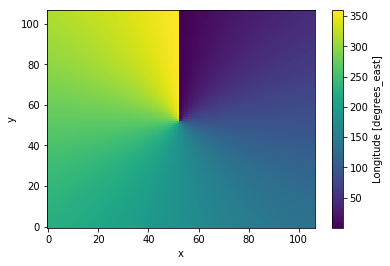

In [203]:
seaIceFlux.lon.plot()
plt.show()

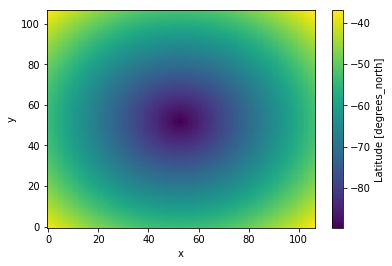

In [219]:
seaIceFlux.lat.plot()
plt.show()

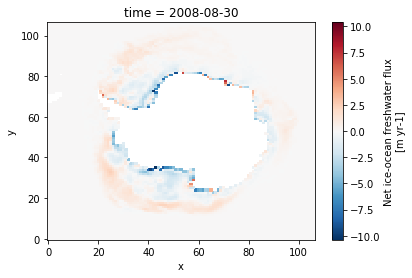

In [205]:
seaIceFlux.net_ioflux[-1].plot()
plt.show()

In [338]:
grid = grid = Grid(seaIceFlux)

In [339]:
grid.diff()

TypeError: diff() missing 2 required positional arguments: 'da' and 'axis'

In [21]:
bathy = xr.open_dataset('/media/data/Datasets/Bathymetry/GEBCO_2014_2D.nc')

In [22]:
bathy

<xarray.Dataset>
Dimensions:    (lat: 21600, lon: 43200)
Coordinates:
  * lat        (lat) float64 -90.0 -89.99 -89.98 -89.97 -89.96 -89.95 -89.95 ...
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 -180.0 -180.0 ...
Data variables:
    elevation  (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        The GEBCO_2014 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The bathymetric portion of the GEBCO_2014 Grid was largely ...
    history:      This is version 20150318 of the data set. Information on th...
    references:   Information on the data set is available from the GEBCO pro...
    comment:      The data in the GEBCO_2014 Grid should not be used for navi...
    node_offset:  1

In [462]:
PEclim

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, month: 12)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 87.0 86.25 85.5 ...
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    e          (month, latitude, longitude) float32 -2.28794e-05 ...
    tp         (month, latitude, longitude) float32 0.000504615 0.000504615 ...

In [343]:
def conv360_180(lons):
    lons[lons > 180] = lons[lons > 180] - 360
    return lons

def conv180_360(lons):
    lons[lons < 0] = lons[lons < 0] + 360

In [304]:
latmin = -69
latmax = -66.7
lonmin = 66
lonmax = 70

In [305]:
PElats = PEclim.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax)).latitude.values
PElons = PEclim.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax)).longitude.values

In [306]:
PEclim.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax)).e.values.shape

(12, 4, 6)

In [307]:
bathy_region = bathy.sel(lat=PElats, lon= conv360_180(PElons), method='nearest').elevation.values
bathy_region_mask = bathy_region < 0

In [308]:
bathy_region_mask.shape

(4, 6)

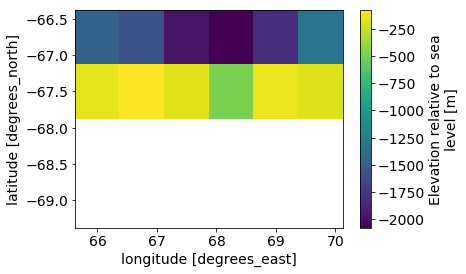

In [309]:
bathy.sel(lat=PElats, lon=PElons, method='nearest').where(bathy_region_mask).elevation.plot()
plt.show()

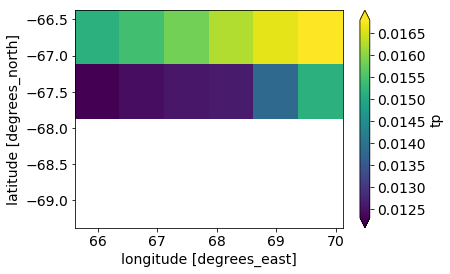

In [310]:
PEclim.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax)).tp.sum(axis=0).where(bathy_region_mask).\
plot(robust=True)
plt.show()

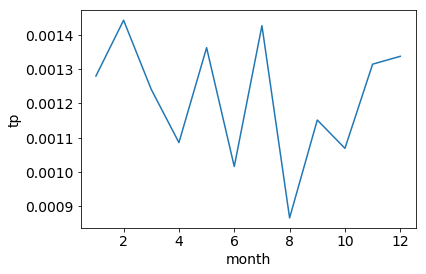

In [311]:
PEclim.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax)).where(bathy_region_mask).tp.\
mean(dim=['latitude', 'longitude']).plot()
plt.show()

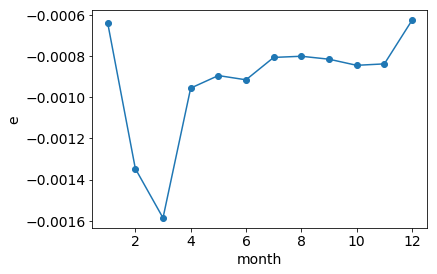

In [312]:
PEclim.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax)).where(bathy_region_mask).e.\
mean(dim=['latitude', 'longitude']).plot(marker='o')
plt.show()

In [313]:
compute_seaIceFlux_regional(latmin= latmin, latmax= latmax, lonmin= lonmin, lonmax= lonmax)

<xarray.DataArray 'net_ioflux' (lat_bins: 1, lon_bins: 1)>
array([[-0.785999]])
Coordinates:
  * lat_bins  (lat_bins) object (-69.0, -66.7]
  * lon_bins  (lon_bins) object (66, 70]

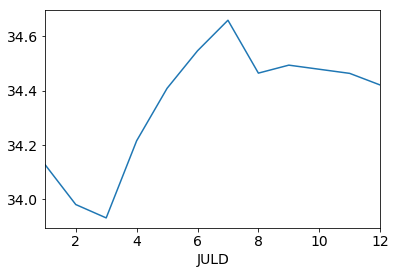

In [315]:
region = CDP
dfmg.loc[region & ~deepMask250 & gline_le_75km, "PSAL_ADJUSTED"].groupby(dfmg.loc[region 
                                                                        & ~deepMask250 & gline_le_75km, "JULD"].\
                                                                         dt.month).mean().plot()
plt.show()

In [316]:
no_of_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [317]:
print(latmin, latmax, lonmin, lonmax)

-69 -66.7 66 70


In [318]:
evap_total = (PEclim.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax)).where(bathy_region_mask).e.\
mean(dim=['latitude', 'longitude'])[1:9] * no_of_days[1:9]).sum()

precip_total = (PEclim.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax)).where(bathy_region_mask).tp.\
mean(dim=['latitude', 'longitude'])[1:9] * no_of_days[1:9]).sum()

seaIceFlux_total = compute_seaIceFlux_regional(latmin= latmin, latmax= latmax, lonmin= lonmin, lonmax= lonmax)

net_FW_flux = precip_total + evap_total + seaIceFlux_total

In [319]:
print(net_FW_flux)

<xarray.DataArray (lat_bins: 1, lon_bins: 1)>
array([[-0.74133]])
Coordinates:
  * lat_bins  (lat_bins) object (-69.0, -66.7]
  * lon_bins  (lon_bins) object (66, 70]


## Ross Sea

160 173 -80 -72.7


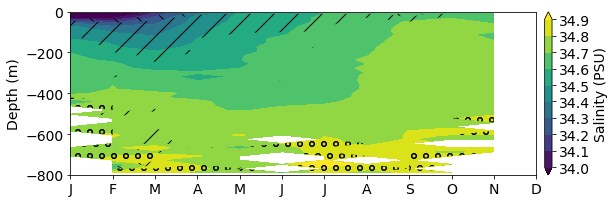

 CTD freshwater estimate =  0.178538698149 
 runoff_2, E + Fice - P =  1.546630647892016 
 runoff_1,  F + E + Fice - P =  1.7251693460407476


In [455]:
latmin, latmax, lonmin, lonmax = -80, -72.7, 160, 173

RS_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[Ross & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/RSA1_sal.png", wd=10, ht=3)

## Weddell Sea

313.7 341 -80 -72.8


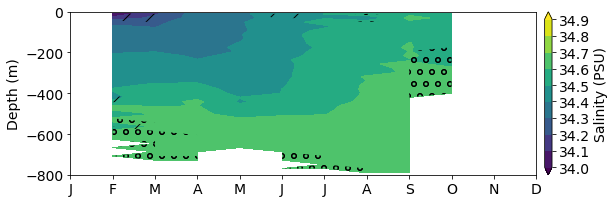

 CTD freshwater estimate =  0.129613593292 
 runoff_2, E + Fice - P =  1.6487522057432216 
 runoff_1,  F + E + Fice - P =  1.7783657990348374


In [457]:
latmin, latmax, lonmin, lonmax = -80, -72.8, -46.3+360, -19+360

WS_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[Weddell & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/WSA1_sal.png", wd=10, ht=3)

## Western Prydz Bay

70 75 -69 -67


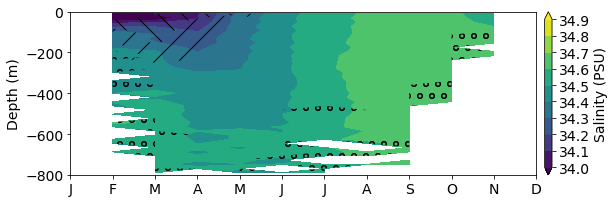

 CTD freshwater estimate =  0.23279908039 
 runoff_2, E + Fice - P =  0.7549950539250858 
 runoff_1,  F + E + Fice - P =  0.9877941343153622


In [458]:
latmin, latmax, lonmin, lonmax = -69, -67, 70, 75

WPB_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[WPB & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/WPBA1_sal.png", wd=10, ht=3)

## Eastern Prydz Bay

75 82 -68.3 -66.8


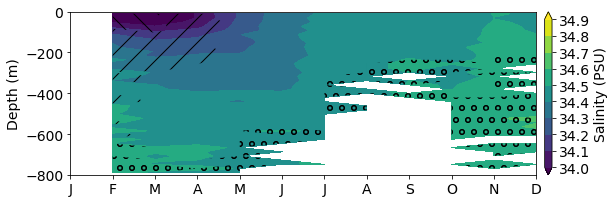

 CTD freshwater estimate =  0.183517803272 
 runoff_2, E + Fice - P =  0.8955433310184162 
 runoff_1,  F + E + Fice - P =  1.0790611342901961


In [459]:
latmin, latmax, lonmin, lonmax = -68.3, -66.8, 75, 82

EPB_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[EPB & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/EPBA1_sal.png", wd=10, ht=3)

## Adelie Coast

135 145 -67 -65.4


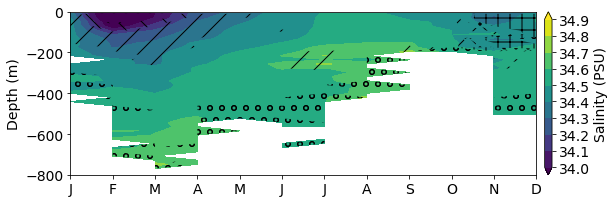

 CTD freshwater estimate =  0.173712993223 
 runoff_2, E + Fice - P =  -0.18877310527022928 
 runoff_1,  F + E + Fice - P =  -0.015060112047396323


In [460]:
latmin, latmax, lonmin, lonmax = -67, -65.4, 135, 145

Adelie_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[Adelie & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/AdelieA1_sal.png", wd=10, ht=3)

## Cape Darnley

In [451]:
import plot_freshwater_vs_years as pltfh
importlib.reload(pltfh)
import plot_Profiles_vs_time as profile2dTime
importlib.reload(profile2dTime)

<module 'plot_Profiles_vs_time' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_Profiles_vs_time.py'>

66 70 -69 -66.7


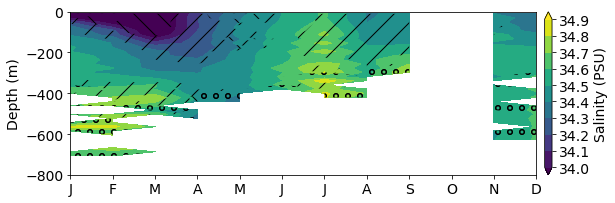

 CTD freshwater estimate =  0.339124352389 
 runoff_2, E + Fice - P =  0.678237617132254 
 runoff_1,  F + E + Fice - P =  1.0173619695213683


In [461]:
latmin = -69
latmax = -66.7
lonmin = 66
lonmax = 70
CD_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[CDP&gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/CDA1_sal.png", wd=10, ht=3)

## Amundsen Sea

240 260 -75.2 -71


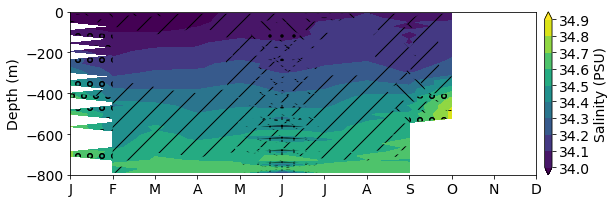

 CTD freshwater estimate =  0.200012957784 
 runoff_2, E + Fice - P =  0.5359387283824617 
 runoff_1,  F + E + Fice - P =  0.7359516861661823


In [462]:
latmin, latmax, lonmin, lonmax = -75.2, -71, -120+360, -100+360

Amundsen_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[Amundsen & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/AmundsenA1_sal.png", wd=10, ht=3)

## EBS

280 300 -73.4 -60.0


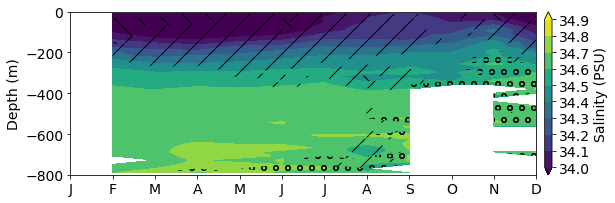

 CTD freshwater estimate =  0.181538912507 
 runoff_2, E + Fice - P =  -0.7280380194424652 
 runoff_1,  F + E + Fice - P =  -0.5464991069353464


In [465]:
latmin, latmax, lonmin, lonmax = -73.4, -60., -80+360, -60+360

EBS_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[EBS & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/EBSA1_sal.png", wd=10, ht=3)

## WBS

260 280 -74.1 -60.0


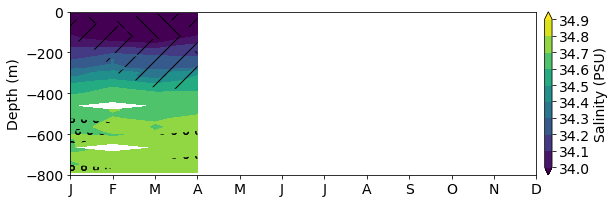

 CTD freshwater estimate =  0.102618485164 
 runoff_2, E + Fice - P =  -0.4790467612911016 
 runoff_1,  F + E + Fice - P =  -0.37642827612685287


In [468]:
latmin, latmax, lonmin, lonmax = -74.1, -60., -100+360, -80+360

WBS_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[WBS & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/WBSA1_sal.png", wd=10, ht=3)

## Knox Coast

In [470]:
dfmg.loc[Knox].LONGITUDE.describe()

count    124116.000000
mean        107.541958
std           2.545542
min         101.002000
25%         106.491600
50%         107.753500
75%         109.495100
max         111.994600
Name: LONGITUDE, dtype: float64

100 112 -67 -60.0


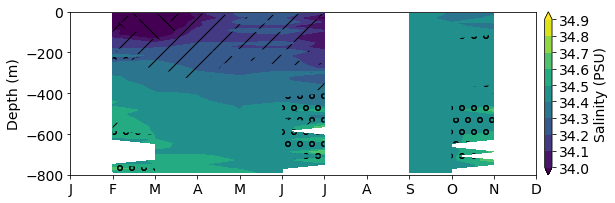

 CTD freshwater estimate =  0.227840227855 
 runoff_2, E + Fice - P =  -0.4199033190961927 
 runoff_1,  F + E + Fice - P =  -0.19206309124114385


In [471]:
latmin, latmax, lonmin, lonmax = -67, -60., 100, 112

Knox_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[Knox & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/KnoxA1_sal.png", wd=10, ht=3)

## Princess Martha Coast

In [474]:
dfmg.loc[PrincessMartha].LONGITUDE.describe()

count    56535.000000
mean       -12.941346
std          6.027682
min        -19.998000
25%        -19.062200
50%        -13.737300
75%         -8.082400
max         -0.027300
Name: LONGITUDE, dtype: float64

341 360 -73 -65.0


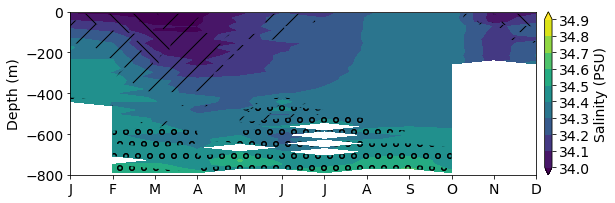

 CTD freshwater estimate =  0.193658240532 
 runoff_2, E + Fice - P =  0.476229615684133 
 runoff_1,  F + E + Fice - P =  0.6698878562157449


In [475]:
latmin, latmax, lonmin, lonmax = -73, -65., -19+360, 360

PMC_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[PrincessMartha & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/PMCA1_sal.png", wd=10, ht=3)

## Prince Harald Coast

In [477]:
dfmg.loc[Harald].LONGITUDE.describe()

count    24142.000000
mean        32.912483
std          1.583536
min         29.017800
25%         32.024100
50%         32.901600
75%         33.651100
max         36.996300
Name: LONGITUDE, dtype: float64

29 37 -69.4 -65.0


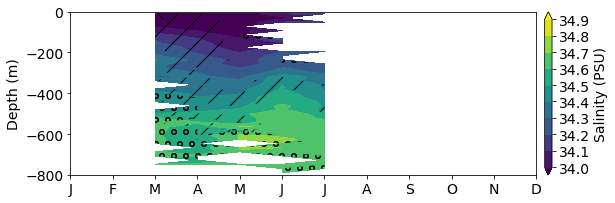

 CTD freshwater estimate =  0.133401380937 
 runoff_2, E + Fice - P =  0.18237522504932713 
 runoff_1,  F + E + Fice - P =  0.3157766059858451


In [478]:
latmin, latmax, lonmin, lonmax = -69.4, -65., 29, 37

PHC_fwf = profile2dTime.compute_freshwater_fluxes(dfmg[Harald & gline_le_75km], 
                                        PEclim, seaIceFlux, bathy,
                                        depth_max=-800, zbin=20,
                                        levs=salrange_disc, save=True, clim=True, lonmin=lonmin, lonmax=lonmax,
                                        latmin = latmin, latmax=latmax,
                                        savename="./Images/seasonal/PHCA1_sal.png", wd=10, ht=3)

In [241]:
min_month = 2
max_month = 7

S_max = dfmg.loc[region & ~deepMask250 & gline_le_75km, "PSAL_ADJUSTED"].groupby(dfmg.loc[region 
                                                                        & ~deepMask250 & gline_le_75km, "JULD"].\
                                                                         dt.month).mean()[min_month - 1]

S_min = dfmg.loc[region & ~deepMask250 & gline_le_75km, "PSAL_ADJUSTED"].groupby(dfmg.loc[region 
                                                                        & ~deepMask250 & gline_le_75km, "JULD"].\
                                                                         dt.month).mean()[max_month - 1]

In [242]:
print(fh_gross)

-105.315451718


In [225]:
tp_clim_regional = PEclim.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax)).tp.sum(axis=0).\
where(bathy_region_mask).mean() * 365

e_clim_regional = PEclim.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax)).e.sum(axis=0).\
where(bathy_region_mask).mean() * 365

seaIceFlux_clim_regional = compute_seaIceFlux_regional(latmin= latmin, latmax= latmax, lonmin= lonmin, lonmax= lonmax)

print(tp_clim_regional, e_clim_regional, seaIceFlux_clim_regional)

<xarray.DataArray 'tp' ()>
array(4.968938268721104) <xarray.DataArray 'e' ()>
array(-3.308460316620767) <xarray.DataArray 'net_ioflux' (lat_bins: 1, lon_bins: 1)>
array([[-0.764458]])
Coordinates:
  * lat_bins  (lat_bins) object (-69.0, -66.7]
  * lon_bins  (lon_bins) object (61, 70]


In [323]:
seaIceFlux.time[-1]

<xarray.DataArray 'time' ()>
array(1220054400000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2008-08-30
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds

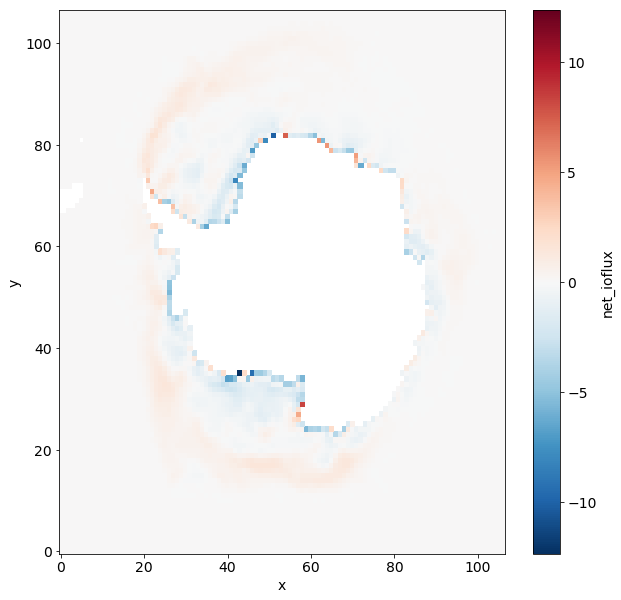

In [329]:
plt.close(1)

fig = plt.figure(1, figsize=(10, 10))
seaIceFlux.net_ioflux.sel(time=slice(np.datetime64("1999-08-30"), np.datetime64("2009-08-30") )).mean(axis=0).plot()
plt.show()

In [171]:
def mean_over_lons(dfg, lonmin, lonmax):
    return dfg.groupby_bins('lon', [lonmin, lonmax]).mean()

def mean_over_lons_alongTime(dfg, lonmin, lonmax):
    return dfg.groupby_bins('lon', [lonmin, lonmax]).mean(axis=1)


def compute_seaIceFlux_regional(latmin, latmax, lonmin, lonmax, timeStart=np.datetime64("2004-08-30"), 
                                timeEnd=np.datetime64("2008-08-30")):
    
    return seaIceFlux.net_ioflux.sel(time=slice(timeStart , timeEnd)).mean(axis=0).\
    groupby_bins('lat', [latmin, latmax]).apply(mean_over_lons, lonmin=lonmin, lonmax=lonmax)
    
def compute_seaIceFlux_regional_alongTime(latmin, latmax, lonmin, lonmax, timeStart=np.datetime64("2004-08-30"), 
                                timeEnd=np.datetime64("2008-08-30")):
    
    return seaIceFlux.net_ioflux.sel(time=slice(timeStart , timeEnd)).\
    groupby_bins('lat', [latmin, latmax]).apply(mean_over_lons_alongTime, lonmin=lonmin, lonmax=lonmax)

In [172]:
compute_seaIceFlux_regional(latmin=-80, latmax=-60, lonmin=300, lonmax=340, timeStart=np.datetime64("1982-08-30"))

<xarray.DataArray 'net_ioflux' (lat_bins: 1, lon_bins: 1)>
array([[-0.123491]])
Coordinates:
  * lat_bins  (lat_bins) object (-80, -60]
  * lon_bins  (lon_bins) object (300, 340]

### Weddell A1

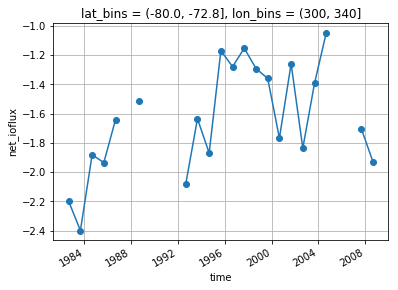

In [107]:
compute_seaIceFlux_regional_alongTime(latmin=-80, latmax=-72.8, lonmin=300, lonmax=340, 
                                      timeStart=np.datetime64("1982-08-30") ).plot(marker='o')
plt.grid()
plt.show()

### Ross A1

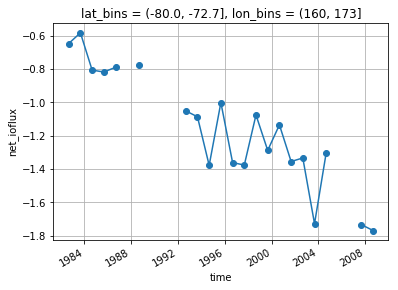

In [111]:
compute_seaIceFlux_regional_alongTime(latmin=-80, latmax=-72.7, lonmin=160, lonmax=173, 
                                      timeStart=np.datetime64("1982-08-30") ).plot(marker='o')
plt.grid()
plt.show()

### Cape Darnley A1

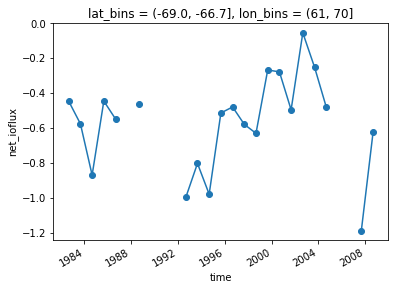

In [105]:
compute_seaIceFlux_regional_alongTime(latmin=-69, latmax=-66.7, lonmin=61, lonmax=70, 
                                      timeStart=np.datetime64("1982-08-30") ).plot(marker='o')
plt.show()

### Western Prydz Bay

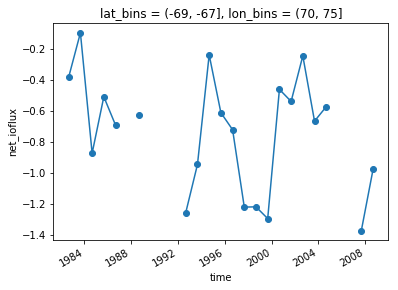

In [106]:
compute_seaIceFlux_regional_alongTime(latmin=-69, latmax=-67, lonmin=70, lonmax=75, 
                                      timeStart=np.datetime64("1982-08-30") ).plot(marker='o')
plt.show()

### Eastern Prydz Bay

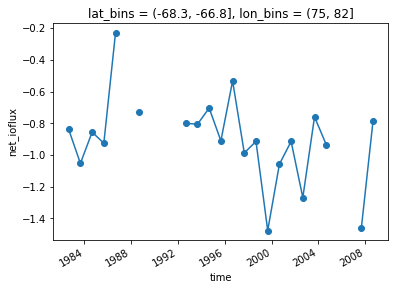

In [109]:
compute_seaIceFlux_regional_alongTime(latmin=-68.3, latmax=-66.8, lonmin=75, lonmax=82, 
                                      timeStart=np.datetime64("1982-08-30") ).plot(marker='o')
plt.show()

### Adelie Coast

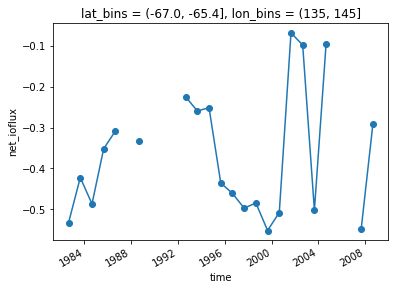

In [110]:
compute_seaIceFlux_regional_alongTime(latmin=-67, latmax=-65.4, lonmin=135, lonmax=145, 
                                      timeStart=np.datetime64("1982-08-30") ).plot(marker='o')
plt.show()

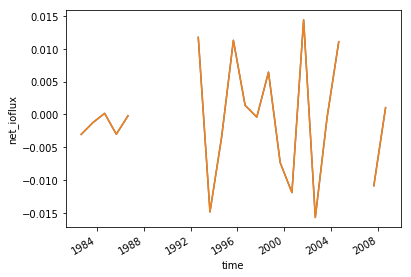

In [77]:
seaIceFlux.net_ioflux.mean(axis=(1,2)).plot()
plt.show()

In [101]:
seaIceFlux.net_ioflux.groupby_bins('lat', [-80, -73]).apply(mean_over_lons, lonmin=300, lonmax=340)

<xarray.DataArray 'net_ioflux' (lat_bins: 1, lon_bins: 1)>
array([[-1.666979]])
Coordinates:
  * lat_bins  (lat_bins) object (-80, -73]
  * lon_bins  (lon_bins) object (300, 340]

In [211]:
seaIceFlux.net_ioflux[-1].sel(x=slice(40,60), y=slice(70,80)).mean()

<xarray.DataArray 'net_ioflux' ()>
array(-2.343501329421997)
Coordinates:
    time     datetime64[ns] 2008-08-30

In [310]:
seaIceFlux_stacked = seaIceFlux.stack(z=('x', 'y') )

In [50]:
def mean_over_lons(dfg, lonmin, lonmax):
    return dfg.groupby_bins('lon', [lonmin, lonmax]).mean()

In [51]:
seaIceFlux_stacked.net_ioflux[-1].groupby_bins('lat', [-80, -60]).apply(mean_over_lons, lonmin=300, lonmax=340)

NameError: name 'seaIceFlux_stacked' is not defined

In [308]:
seaIceFlux_stacked.net_ioflux.sel(time=slice(np.datetime64("2004-08-30"), np.datetime64("2008-08-30") ))\
.mean(axis=0).sel(lon=slice(300,340))

<xarray.DataArray 'net_ioflux' (z: 11449)>
array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)
Coordinates:
    lon      (z) float32 225.182 225.735 226.298 226.872 227.457 228.053 ...
    lat      (z) float32 -38.0239 -38.5511 -39.0718 -39.5861 -40.0938 ...
  * z        (z) MultiIndex
  - x        (z) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - y        (z) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

In [148]:
seaIceFlux_current = seaIceFlux.sel(time=slice(np.datetime64("2004-08-30"), np.datetime64("2008-08-30") )).mean(axis=0)

In [156]:
seaIceFlux_current

<xarray.Dataset>
Dimensions:         (x: 107, y: 107)
Dimensions without coordinates: x, y
Data variables:
    mask            (x) float32 0.953271 0.953271 0.962617 0.953271 0.962617 ...
    zero_line       (x) float32 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    cell_area       (x) float32 5.71295e+09 5.71204e+09 5.71118e+09 ...
    net_ioflux      (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    net_ioflux_div  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    u_flux          (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    v_flux          (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [158]:
seaIceFlux_current2 = xr.DataArray(seaIceFlux_current.net_ioflux.values, coords=[seaIceFlux.lon.values, seaIceFlux.lat.values], 
                                   dims=['longitude', 'latitude'])

MissingDimensionsError: cannot set variable 'longitude' with 2-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.

In [331]:
dfmg.loc[~dfmg.PSAL_ADJUSTED.isnull(), 'PSAL_ADJUSTED'].count()

2741783

In [334]:
dfmg.PSAL_ADJUSTED.count()

2741783